## Import Dependencies and Bring in Data

In [2]:
# importing required libraries

import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
# load the dataset

df = pd.read_csv('train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Preprocess

In [5]:
# import TextVectorization layer (use to convert text into integer sequences)

from tensorflow.keras.layers import TextVectorization

In [6]:
# seperating features and labels
# X: raw comment text
# y: multi-label target

X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
# define vocabulary size: how many unique words we let the model learn

MAX_FEATURES = 200000

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

# create a TextVextorization layer:
# - limits vocab to MAX_FEATURES most common words
# - truncates sequence to length 1800
# - converts words into integer IDs

In [9]:
# "Fit" the vectorizer on the text data so it learns the vocabulary

vectorizer.adapt(X.values)

In [10]:
# transform raw text into integer sequence using the fitted vectorizer

vectorized_text = vectorizer(X.values)

In [11]:
# display the vectorized output (numeric representation of comments)

vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [12]:
# MCSHBAP: Map, Cache, Shuffle, Batch, Prefetch
# Build an optimized TensorFlow dataset pipeline

# create a dataset from the vectorized comments (X) and labels (y)
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))

# cache data in memeory for faster training (avoids re-reading each epoch)
dataset = dataset.cache()

# shuffle samples to break any ordering patterns in the dataset
dataset = dataset.shuffle(160000)

# batch the data (16 sample oper steps) for efficient training
dataset = dataset.batch(16)

# prepare next batches while current batch is being processed (pipeline optimization)
dataset = dataset.prefetch(8)

In [13]:
# tale one batch of (inputs, labels) as NumPy arrays to inspect the format

batch_X, batch_y = dataset.as_numpy_iterator().next()

In [14]:
# split into 70% train, 20% validation (for tuning and checking overfitting), 10% test

train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

## Create Sequential Model

In [15]:
# import layers for building the neural network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()

# create an Embedding layer: maps word IDs to dense vectors (word representations)
model.add(Embedding(input_dim=MAX_FEATURES+1, output_dim=32))

# Bidirectional LSTM: process sequences both forward and backword
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Fully connected layers for feature extraction
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer: 6 nueurons (one per class), sigmoid for multi-label classification
model.add(Dense(6, activation='sigmoid'))

In [17]:
# define expected input shape: (batch_size, sequence_length)

model.build(input_shape=(None, 1800))

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

# compile the model:
# - loss: BinaryCrossentropy (since it's multi-label classification)
# - optimizer: Adam (effiecient gradient descent method)

In [19]:
# display model architecture, layer types, output shapes, and parameter counts

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# training the model for 5 epoch and validate on val set

history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 660s 94ms/step - loss: 0.0859 - val_loss: 0.0461
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 649s 93ms/step - loss: 0.0478 - val_loss: 0.0413
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 669s 96ms/step - loss: 0.0414 - val_loss: 0.0365
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 666s 93ms/step - loss: 0.0382 - val_loss: 0.0335
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 662s 95ms/step - loss: 0.0343 - val_loss: 0.0300


In [21]:
# show training history

history.history

{'loss': [0.06454436480998993,
  0.04702506214380264,
  0.04178771749138832,
  0.03797517716884613,
  0.03440295159816742],
 'val_loss': [0.04612816497683525,
  0.04128041863441467,
  0.036493800580501556,
  0.03347467631101608,
  0.030001986771821976]}

<Figure size 800x500 with 0 Axes>

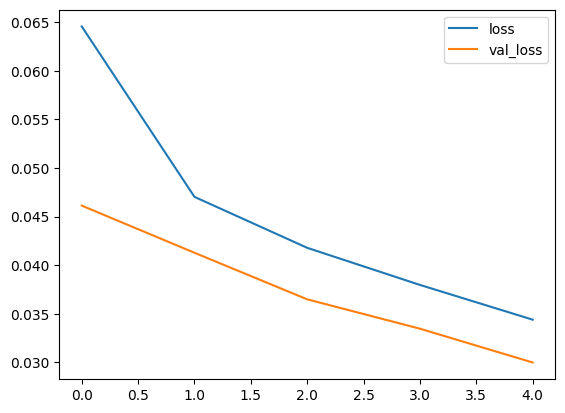

In [22]:
from matplotlib import pyplot as plt

# visualize the training history
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Make Prediction

In [23]:
# vectorize a new input sentence (convert text into integer IDs)

input_text = vectorizer('You suck! I am coming for you!')

In [24]:
# Run the model on this input (expand_dims adds batch dimention ➡️ shape (1, 1800))

res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


In [25]:
# convert predictions to binary labels

(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [26]:
# get one batch of test data (inputs and true labels)

batch_X, batch_y = test.as_numpy_iterator().next()

In [27]:
# run predictions on the batch and threshold at 0.5 to get binary labels

(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [28]:
# display true labels for the batch

batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [29]:
# check prediction array shape

res.shape

(1, 6)

## Evaluate the Model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [31]:
# initialize evaluation metrics

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [32]:
# loop through all batches in the test set
for batch in test.as_numpy_iterator():

  # unpack inputs (X_true) and labels (y_true)
  X_true, y_true = batch

  # make predictions
  yhat = model.predict(X_true)

  # flatten labels and predictions (so metrics can be computed easily)
  # flatten (batch_size, 6) → (batch_size*6, )
  y_true = y_true.flatten()
  yhat = yhat.flatten()

  # update running metrics with this batch
  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━

In [33]:
# print final metric results across the test set

print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8642786741256714, Recall:0.7864832282066345, Accuracy:0.49448344111442566


## Test and Gradio

In [34]:
import gradio as gr

In [35]:
# save the trained model

model.save('toxicity.h5')

In [36]:
# reload the trained model from disk

model = tf.keras.models.load_model('toxicity.h5')

In [37]:
# quick test on a new input

input_str = vectorizer('hey I freaking hate you')

In [38]:
res = model.predict(np.expand_dims(input_str, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


In [39]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [40]:
# raw prediction values (probabilites for each class)

res

array([[0.8331678 , 0.04414992, 0.12134945, 0.1125765 , 0.34333247,
        0.2712882 ]], dtype=float32)

In [41]:
# define a function to score a comment and return readable results
def score_comment(comment):

  # vectorize input comment
  vectorized_comment = vectorizer([comment])

  # run prediction
  results = model.predict(vectorized_comment)

  # build readable output text
  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

In [42]:
# create a Gradio interface for interactive testing

interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs = 'text')

In [43]:
# Launch the interface (share=True → creates a public link)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7c9e17ee1a5659bdb3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
